In [16]:
from functions import (prep, folding, inbu, LSTM_model)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
np.random.seed(42)
source = "running-example"
flatten_by = input("Enter the value for flatten_by (Orders, Items or Packages): ")
single_log = input("Enter the value for single_log (True/False): ")
complete = input("Enter the value for complete (True/False): ")

# Error handling for invalid input values
if flatten_by not in ['Orders', 'Items', 'Packages']:
    raise ValueError("Wrong Input: flatten_by must be one of ['Orders', 'Items', 'Packages']")

if single_log.lower() not in ['true', 'false', '1', '0']:
    raise ValueError("Wrong Input: single_log must be a boolean value (True/False)")

if complete.lower() not in ['true', 'false', '1', '0']:
    raise ValueError("Wrong Input: complete must be a boolean value (True/False)")

# Convert input values to boolean
single_log = single_log.lower() in ['true', '1']
complete = complete.lower() in ['true', '1'] 
if complete:
    csvname = flatten_by  + '_complete'
    fl = None
else:
    csvname = flatten_by  + '_filter'
    fl = prep.act_filter(flatten_by )

time_feat = ['Time_Diff', 'Time_Since_Start', 'Time_Since_Midnight','Weekday','Position']
other_features = ['Amount_Items','In_Package']
drops_col_order = ["weight", "price", "Event_ID", 'Products']

In [17]:
## prep the ocel and readin
ocel, act_dict, cust_dict = prep.prepare_flat_ocel(source, flatten_on= flatten_by , filter= fl)
print(act_dict)
print(cust_dict)
## create the enriched and some more preprocessing as well as saving the single and enriched versions
ocel = prep.gen_enriched_single_plus_csv(OCEL = ocel,flatted_by = flatten_by ,csvname = csvname, drops_col= drops_col_order)
## adding features
ocel =prep.generate_features(ocel)
divisor = np.mean(ocel['Time_Diff'])  # average time between events
divisor2 = np.mean(ocel['Time_Since_Start'])  # average time between current and first events
divisorTR = np.mean(ocel['Remaining_Time'])  # average time instance remaining
divisor3 = ocel.groupby('Case_ID')['Time_Since_Start'].apply(lambda x: (x.iloc[-1] - x).mean()).mean()

print(f"divisor: {divisor}")
print(f"divisor2: {divisor2}")
print(f"divisorTR: {divisorTR}")
print(f"divisor3: {divisor3}")
print(len(ocel))

#folding the data 
ocel_train, ocel_test = folding.folding_train_test(ocel)

{'place order': 'A', 'confirm order': 'B', 'pay order': 'C', 'payment reminder': 'D'}
{'Marco Pegoraro': 'a', 'Gyunam Park': 'b', 'Majid Rafiei': 'c', 'Junxiong Gao': 'd', 'Seran Uysal': 'e', 'Christina Rensinghof': 'f', 'Wil van der Aalst': 'g', 'Christine Dobbert': 'h', 'Luis Santos': 'i', 'Kefang Ding': 'j', 'Mohammadreza Fani Sani': 'k', 'Tobias Brockhoff': 'l', 'Anahita Farhang Ghahfarokhi': 'm', 'Mahnaz Qafari': 'n', 'Claudia Graf': 'o', 'Mahsa Bafrani': 'p', 'Lisa Mannel': 'q'}
divisor: 318986.03791832976
divisor2: 528541.2252072459
divisorTR: 679045.650752226
divisor3: 591967.807807143
6514


defining the features

In [20]:

act_feat = list(filter(lambda k: k.startswith('Act_') and not k.startswith('Next_Act_'), ocel_train.columns))
target_act_feat = list(filter(lambda k: k.startswith('Next_Act_') and not k.startswith('Act_'), ocel_train.columns))
act_feat.remove('Act_!')
cust_feat = list(filter(lambda k: 'Cust_' in k, ocel_train.columns))

feature_select = act_feat + cust_feat * (single_log -1) + time_feat + other_features *(single_log -1)
print(f"Length of act_feat: {len(act_feat)}, Length of cust_feat: {len(cust_feat)}")

## define dimensions of inputs
traces, max_trace_length = prep.gen_traces_and_maxlength_of_trace(ocel)
target_act_length = len(target_act_feat)
number_of_train_cases = len(ocel_train)
num_of_features = len(feature_select)
print(f"Number of train cases: {number_of_train_cases}, Max trace length: {max_trace_length}, Number of features: {num_of_features}")



Length of act_feat: 4, Length of cust_feat: 18
Number of train cases: 4366, Max trace length: 9, Number of features: 9


get the inputs 

In [21]:
num_of_features

9

In [23]:
X_train,y_train_a, y_train_t, y_train_tr = inbu.generating_inputs(OCEL=ocel_train,
                                                                  num_of_features=num_of_features,
                                                                  taf=target_act_feat,
                                                                  act=act_feat,
                                                                  custf=cust_feat,
                                                                  divisor_next=divisor,
                                                                  divisor_since=divisor2,
                                                                  divisor_remaining=divisorTR, 
                                                                  single= single_log)

print(f"Shape of X_train: {X_train.shape}")
print(f"This matches the desired shape (number_of_train_cases, max_trace_length, num_of_features): {(number_of_train_cases, max_trace_length, num_of_features)} => {X_train.shape ==(number_of_train_cases, max_trace_length, num_of_features)}")
print(f"Shape of y_train_a: {y_train_a.shape}, this matches the desired shape (number_of_train_cases, target_act_length): {(number_of_train_cases, target_act_length)} => {y_train_a.shape ==(number_of_train_cases, target_act_length)}")
print(f"Shape of y_train_t: {y_train_t.shape}, this matches the desired shape (number_of_train_cases, ): {(number_of_train_cases, )} => {y_train_t.shape ==(number_of_train_cases, )}")
print(f"Shape of y_train_tr: {y_train_tr.shape}, this matches the desired shape (number_of_train_cases, ): {(number_of_train_cases, )} => {y_train_tr.shape ==(number_of_train_cases, )}")


Shape of X_train: (4366, 9, 9)
This matches the desired shape (number_of_train_cases, max_trace_length, num_of_features): (4366, 9, 9) => True
Shape of y_train_a: (4366, 5), this matches the desired shape (number_of_train_cases, target_act_length): (4366, 5) => True
Shape of y_train_t: (4366,), this matches the desired shape (number_of_train_cases, ): (4366,) => True
Shape of y_train_tr: (4366,), this matches the desired shape (number_of_train_cases, ): (4366,) => True


In [24]:

if single_log:
    model_file = csvname + '_single'
else:
    model_file = csvname + '_enriched'
history = LSTM_model.LSTM_MODEL(X_train, y_train_a, y_train_t, y_train_tr,filename=model_file)

Build model...
Epoch 1/500
388/388 - 9s - loss: 1.9008 - act_output_loss: 0.5006 - time_output_loss: 0.9010 - timeR_output_loss: 0.4992 - val_loss: 1.3364 - val_act_output_loss: 0.2038 - val_time_output_loss: 0.6900 - val_timeR_output_loss: 0.4426
Epoch 2/500
388/388 - 3s - loss: 1.5159 - act_output_loss: 0.2550 - time_output_loss: 0.7957 - timeR_output_loss: 0.4652 - val_loss: 1.3280 - val_act_output_loss: 0.2084 - val_time_output_loss: 0.6781 - val_timeR_output_loss: 0.4416
Epoch 3/500
388/388 - 3s - loss: 1.4705 - act_output_loss: 0.2391 - time_output_loss: 0.7727 - timeR_output_loss: 0.4588 - val_loss: 1.3202 - val_act_output_loss: 0.2008 - val_time_output_loss: 0.6823 - val_timeR_output_loss: 0.4372
Epoch 4/500
388/388 - 3s - loss: 1.4746 - act_output_loss: 0.2464 - time_output_loss: 0.7721 - timeR_output_loss: 0.4561 - val_loss: 1.3066 - val_act_output_loss: 0.1897 - val_time_output_loss: 0.6754 - val_timeR_output_loss: 0.4415
Epoch 5/500
388/388 - 3s - loss: 1.4726 - act_output_

dict_keys(['loss', 'act_output_loss', 'time_output_loss', 'timeR_output_loss', 'val_loss', 'val_act_output_loss', 'val_time_output_loss', 'val_timeR_output_loss', 'lr'])


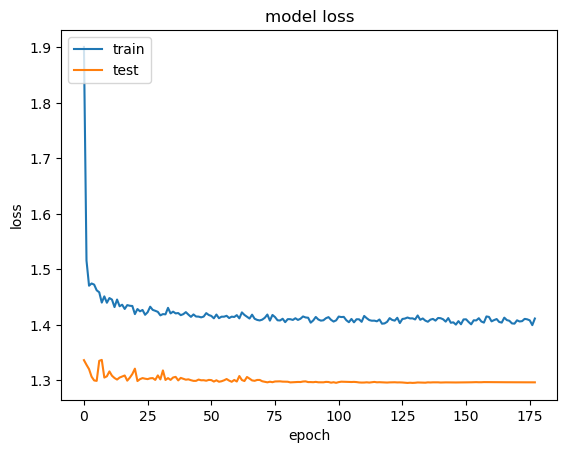

In [25]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
import csv
from datetime import timedelta
import distance
from jellyfish import damerau_levenshtein_distance
from keras.models import load_model
from numpy.compat import unicode
from sklearn import metrics

modelname = 'model_Orders_filter_single_128-1.30.h5'
model = load_model(f'./output_files/models/{modelname}')

predict_size = max_trace_length

# Get all unique activities in the DataFrame
chars = sorted(set(ocel['Activity'].unique()))
# Add '!' to the target_chars
target_chars = chars + ['!']
char_indices = dict((c, i) for i, c in enumerate(chars))
target_indices = dict((c, i) for i, c in enumerate(target_chars))
target_indices_char = dict((i,c) for i, c in enumerate(target_chars))


# define helper functions
def encode(sentence, times, times3, maxlen=max_trace_length):
    num_features = len(chars) + 5
    X = np.zeros((1, max_trace_length, num_features), dtype=np.float32)
    leftpad = max_trace_length - len(sentence)
    times2 = np.cumsum(times)
    for t, char in enumerate(sentence):
        midnight = times3[t].replace(hour=0, minute=0, second=0, microsecond=0)
        timesincemidnight = times3[t] - midnight
        for c in chars:
            if c == char:
                X[0, t + leftpad, char_indices[c]] = 1
        X[0, t + leftpad, len(chars)] = t + 1
        X[0, t + leftpad, len(chars) + 1] = times[t] / divisor
        X[0, t + leftpad, len(chars) + 2] = times2[t] / divisor2
        X[0, t + leftpad, len(chars) + 3] = timesincemidnight.seconds / 86400
        X[0, t + leftpad, len(chars) + 4] = times3[t].weekday() / 7
    return X


def getSymbol(predictions):
    maxPrediction = 0
    symbol = ''
    i = 0
    for prediction in predictions:
        if prediction >= maxPrediction:
            maxPrediction = prediction
            symbol = target_indices_char[i]
        i += 1
    return symbol


one_ahead_gt = []
one_ahead_pred = []

two_ahead_gt = []
two_ahead_pred = []

three_ahead_gt = []
three_ahead_pred = []
flag = False
# Preallocate lists for storing results
results = []
with open('./output_files/results/suffix_and_remaining_time_%s.csv' % csvname, 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(["CaseID", "Prefix length", "Ground truth", "Predicted", "Levenshtein", "Damerau", "Jaccard",
                         "Ground truth times", "Predicted times", "RMSE", "MAE"])

# Get relevant columns from the grouped data
group_columns = ['Case_ID', 'Activity', 'Time_Diff', 'Time_Since_Start', 'Timestamp']
grouped_data = ocel_test.groupby('Case_ID')[group_columns]

# Iterate over different prefix sizes
for prefix_size in range(2, max_trace_length):
    print(prefix_size)
    
    # Iterate over each case
    for case_id, group in grouped_data:
        if case_id == '990265':
            flag = True
            break
        line = group['Activity'].values
        Ptimes = group['Time_Diff'].values
        Ptimes2 = group['Time_Since_Start'].values
        Ptimes3 = pd.to_datetime(group['Timestamp']).dt.to_pydatetime().tolist()

        Ptimes = np.append(Ptimes, 0)
        cropped_line = ''.join(line[:prefix_size])
        cropped_times = Ptimes[:prefix_size]
        cropped_times3 = Ptimes3[:prefix_size]  # Convert numpy.datetime64 array to list

        if len(Ptimes2) < prefix_size:
            continue  # make no prediction for this case, since this case has ended already

        ground_truth = ''.join(line[prefix_size:prefix_size + predict_size])
        ground_truth_t = Ptimes2[prefix_size - 1]
        case_end_time = Ptimes2[-1]
        ground_truth_t = case_end_time - ground_truth_t

        predicted = ''
        total_predicted_time = 0

        for i in range(predict_size):
            enc = encode(cropped_line, cropped_times, cropped_times3)
            y = model.predict(enc, verbose=0)  # make predictions

            # split predictions into separate activity and time predictions
            y_char = y[0][0]
            y_t = y[1][0][0]
            prediction = getSymbol(y_char)  # undo one-hot encoding
            cropped_line += prediction

            y_t = np.maximum(y_t, 0)
            y_t1 = y_t * divisor
            cropped_times = np.append(cropped_times, y_t1)

            if prediction == '!':  # end of case was just predicted, therefore, stop predicting further into the future
                one_ahead_pred.append(total_predicted_time)
                one_ahead_gt.append(ground_truth_t)
                print('! predicted, end case')
                break

            y_t = y_t * divisor3
            next_time = cropped_times3[-1] + timedelta(seconds=y_t)
            cropped_times3.append(next_time)  # Append new datetime object
            total_predicted_time += y_t
            predicted += prediction

        output = []
        if len(ground_truth) > 0:
            output.append(case_id)
            output.append(prefix_size)
            output.append(str(ground_truth))
            output.append(str(predicted))
            output.append(1 - distance.nlevenshtein(predicted, ground_truth))
            dls = 1 - (damerau_levenshtein_distance(str(predicted), str(ground_truth)) / max(len(predicted), len(ground_truth)))
            dls = np.maximum(dls, 0)
            output.append(dls)
            output.append(1 - distance.jaccard(predicted, ground_truth))
            output.append(ground_truth_t)
            output.append(total_predicted_time)
            output.append('')
            output.append(metrics.mean_absolute_error([ground_truth_t], [total_predicted_time]))
            results.append(output)

    if flag:
        break
with open('./output_files/results/suffix_and_remaining_time_%s.csv' % csvname, 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    # Write results to CSV
    spamwriter.writerows(results)

2


In [ ]:
# 990265 in 35
# in 36.3 new in 34

#         if flag:
#             break 
#         # Iterate over each case
#         for case_id, group in grouped_data:
#             if case_id == '990265':
#                 flag = True
#                 break